In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
import os
from pathlib import Path
import cv2
import PIL
from moviepy.editor import *

In [21]:
def visualize_maps_and_scene(map_dir='.', n_maps=10, num_to_skip=0,
                             get_from_back=False, make_movie=False):
    paths = sorted(Path(map_dir).iterdir(), key=os.path.getmtime)
    n_layers = 4
    map_names = [str(name) for name in paths if 'obstacle_map_159' in str(name)]
    ray_names = [str(name) for name in paths if 'obstacle_ray_map' in str(name)]
    rgb_names = [str(name) for name in paths if 'rgb' in str(name)]
    depth_names = [str(name) for name in paths if 'depth' in str(name)]

    if get_from_back:
        map_names = map_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        ray_names = ray_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        rgb_names = rgb_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
        depth_names = depth_names[-(num_to_skip + n_maps):(-num_to_skip or None)]
    else:
        map_names = map_names[num_to_skip:num_to_skip + n_maps]
        ray_names = ray_names[num_to_skip:num_to_skip + n_maps]
        rgb_names = rgb_names[num_to_skip:num_to_skip + n_maps]
        depth_names = depth_names[num_to_skip:num_to_skip + n_maps]

    maps = []
    for i, name in enumerate(map_names):
        print(name)
        if 'npz' in name:
            obs_map = np.load(name)['arr_0']
        else:
            obs_map = np.loadtxt(name)
            
        map_scale = 80

        # plt.imshow(obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale])
        cont_map = obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
        
        cont_map = cv2.resize(cont_map, (480, 480))
        # maps.append(cont_map)
        thres_map = (obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
                     > 128).astype(float)
        
        kernel = np.ones((5,5),np.uint8)
        thres_map = cv2.morphologyEx(thres_map, cv2.MORPH_CLOSE, kernel)
        
        thres_map = cv2.resize(thres_map, (480, 480)).round().astype(int)
        maps.append(thres_map * 10)
        
        ray_name = ray_names[i]
        if 'npz' in ray_name:
            ray_map = np.load(ray_name)['arr_0']
        else:
            ray_map = np.loadtxt(ray_name)
        ray_map = ray_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale]
        ray_map = cv2.resize(ray_map, (480, 480)).astype(np.int64)
        ray_map += thres_map
        maps.append(ray_map)
        
        if '.npy' in rgb_names[i]:
            maps.append(np.load(rgb_names[i]))
        else:
            maps.append(np.array(PIL.Image.open(rgb_names[i])))
        if '.npy' in depth_names[i]:
            maps.append(np.load(depth_names[i]).squeeze(2))
        else:
            maps.append(np.array(PIL.Image.open(depth_names[i])))
    
    prefix = 'maps/visualizations/'
    suffix = '_'.join(map_names[0].split('_')[-2:]).split('.')[0]    

    if make_movie:
        frames = np.zeros([len(map_names), 480 * 2, 480 + 640, 3])
        locations = [
            [0, 0],
            [480, 0],
            [0, 480],
            [480, 480],
        ]
        
        for i, image in enumerate(maps):
            location = locations[i % n_layers]
            frame_id = i // n_layers
            shape = image.shape
            
            if len(shape) == 2:
                image = (image / image.max() * 255).astype(int)
                frames[frame_id, location[0]:location[0] + shape[0],
                       location[1]:location[1] + shape[1],0] = image
            else:
                frames[frame_id, location[0]:location[0] + shape[0],
                       location[1]:location[1] + shape[1]] = image
        
        movie = ImageSequenceClip(list(frames), fps=1.5)
        movie.write_videofile(prefix + suffix + '.mp4')
        
    else:
        fig = plt.figure(figsize=(6 * n_layers, 6 * n_maps))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(n_maps, n_layers),  # creates 2x2 grid of axes
                         axes_pad=0.1,  # pad between axes in inch.
                         )

        for ax, im in zip(grid, maps):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)

        fig.tight_layout()
        plt.savefig(prefix + suffix + '.png')
        plt.show()

In [23]:
visualize_maps_and_scene('maps/objectgoal_1591096031', num_to_skip=0,
                         n_maps=100, get_from_back=True, make_movie=True)

maps/objectgoal_1591096031/obstacle_map_1591096032_83106.npz
maps/objectgoal_1591096031/obstacle_map_1591096032_117536.npz
maps/objectgoal_1591096031/obstacle_map_1591096032_117557.npz
maps/objectgoal_1591096031/obstacle_map_1591096033_155519.npz
maps/objectgoal_1591096031/obstacle_map_1591096033_203209.npz
maps/objectgoal_1591096031/obstacle_map_1591096033_249166.npz
maps/objectgoal_1591096031/obstacle_map_1591096034_305480.npz
maps/objectgoal_1591096031/obstacle_map_1591096034_360411.npz
maps/objectgoal_1591096031/obstacle_map_1591096034_402133.npz
maps/objectgoal_1591096031/obstacle_map_1591096035_446196.npz
maps/objectgoal_1591096031/obstacle_map_1591096035_482125.npz
maps/objectgoal_1591096031/obstacle_map_1591096035_505389.npz
maps/objectgoal_1591096031/obstacle_map_1591096036_534402.npz
maps/objectgoal_1591096031/obstacle_map_1591096036_562870.npz
maps/objectgoal_1591096031/obstacle_map_1591096036_590811.npz
maps/objectgoal_1591096031/obstacle_map_1591096036_612726.npz
maps/obje

t:   9%|▉         | 9/99 [00:00<00:01, 83.05it/s, now=None]

Moviepy - Building video maps/visualizations/1591096032_83106.mp4.
Moviepy - Writing video maps/visualizations/1591096032_83106.mp4



Moviepy - Done !
Moviepy - video ready maps/visualizations/1591096032_83106.mp4


maps/objectgoal_1591092516/obstacle_map_1591092527_18272.npz
maps/objectgoal_1591092516/obstacle_map_1591092527_38948.npz
maps/objectgoal_1591092516/obstacle_map_1591092528_66089.npz
maps/objectgoal_1591092516/obstacle_map_1591092529_31068.npz
maps/objectgoal_1591092516/obstacle_map_1591092530_41766.npz
maps/objectgoal_1591092516/obstacle_map_1591092530_44948.npz
maps/objectgoal_1591092516/obstacle_map_1591092531_52001.npz
maps/objectgoal_1591092516/obstacle_map_1591092532_15354.npz
maps/objectgoal_1591092516/obstacle_map_1591092532_21285.npz
maps/objectgoal_1591092516/obstacle_map_1591092532_30363.npz
maps/objectgoal_1591092516/obstacle_map_1591092533_44755.npz
maps/objectgoal_1591092516/obstacle_map_1591092533_59910.npz
maps/objectgoal_1591092516/obstacle_map_1591092534_76952.npz
maps/objectgoal_1591092516/obstacle_map_1591092535_55771.npz
maps/objectgoal_1591092516/obstacle_map_1591092536_68274.npz
maps/objectgoal_1591092516/obstacle_map_1591092536_73634.npz
maps/objectgoal_15910925

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.7/site-packages/ipykernel/__main__.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


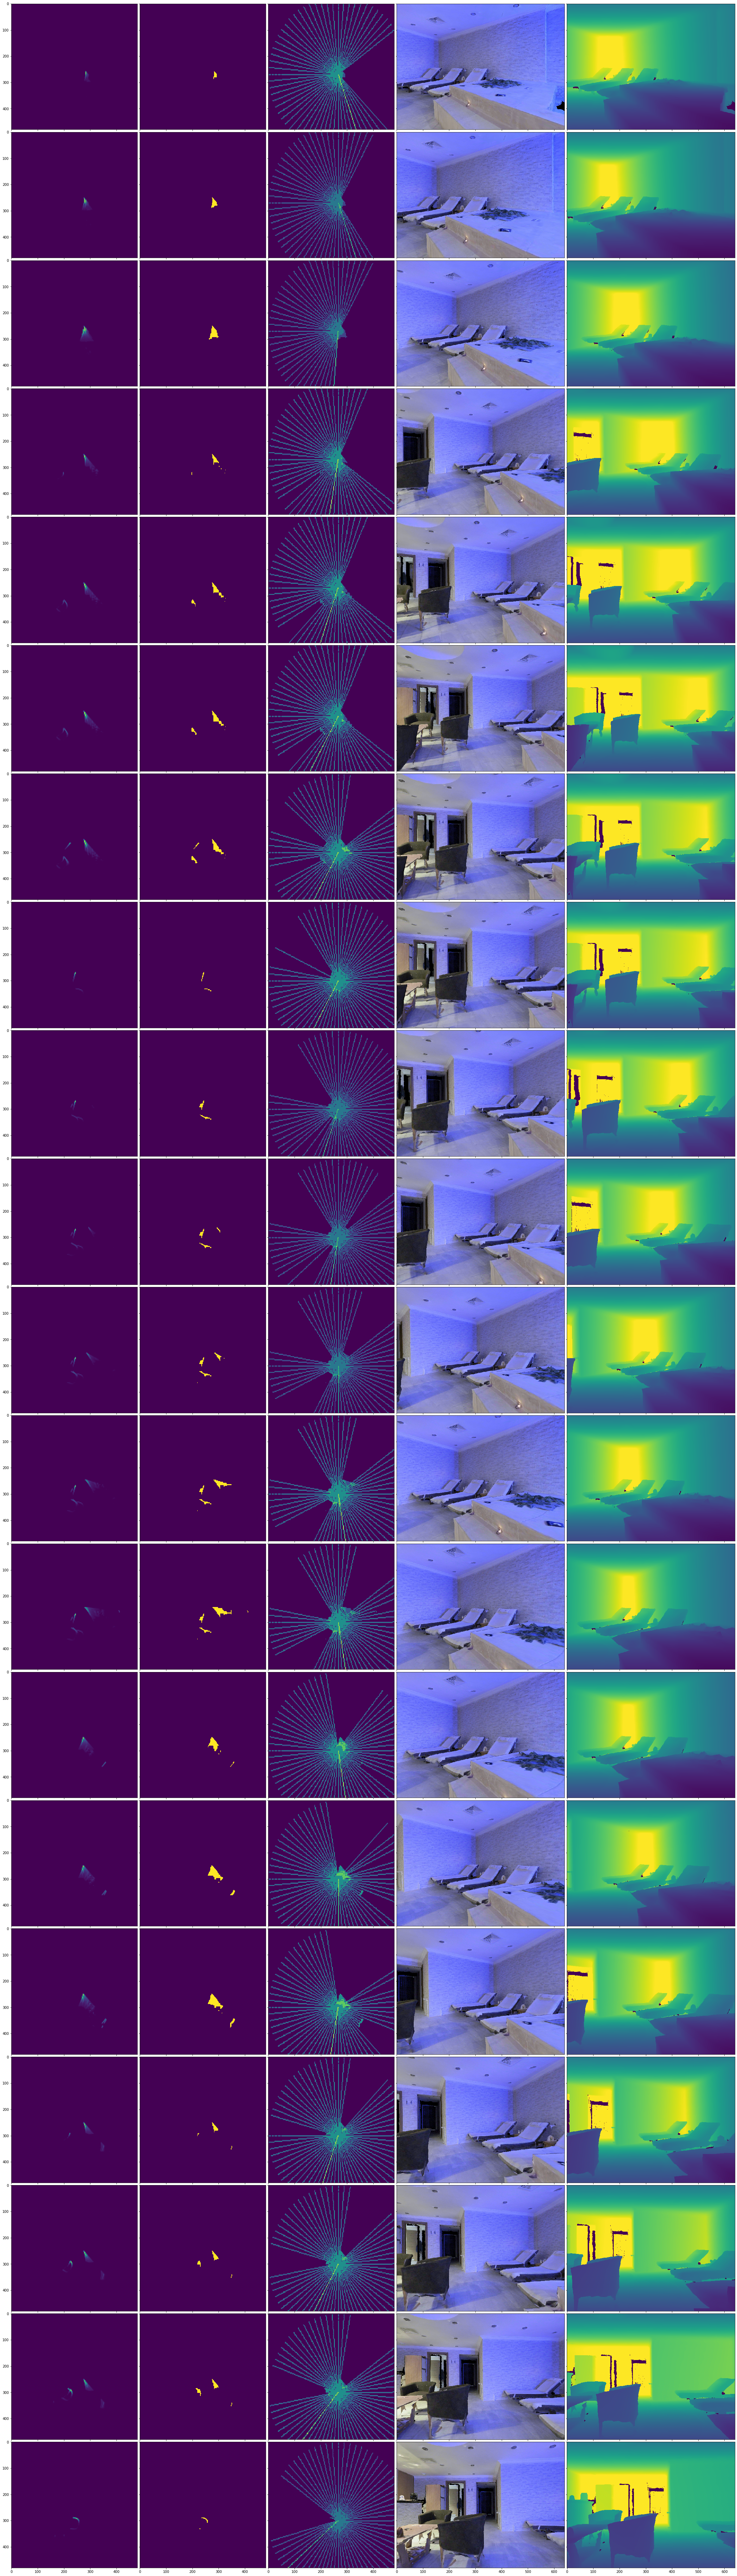

In [5]:
visualize_maps_and_scene('maps/objectgoal_1591092516', num_to_skip=0, n_maps=20, get_from_back=True)

In [24]:
obs_map = np.loadtxt("obstacle_map_tensor(102959., device='cuda:0').csv")
obs_map.shape, obs_map.sum()

((400, 400), 102959.0)

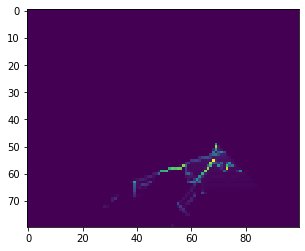

In [25]:
map_scale = 40
plt.imshow(obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale])

In [31]:
np.maxiumum(obs_map, 10)

AttributeError: module 'numpy' has no attribute 'maxiumum'

In [35]:
sorted(obs_map.flatten(), reverse=True)

[2582.0,
 2361.0,
 2202.0,
 2184.0,
 2156.0,
 2123.0,
 2053.0,
 1997.0,
 1962.0,
 1951.0,
 1860.0,
 1805.0,
 1785.0,
 1739.0,
 1669.0,
 1669.0,
 1652.0,
 1648.0,
 1470.0,
 1417.0,
 1335.0,
 1325.0,
 1314.0,
 1294.0,
 1281.0,
 1245.0,
 1179.0,
 1089.0,
 1083.0,
 1039.0,
 1022.0,
 974.0,
 944.0,
 910.0,
 891.0,
 876.0,
 840.0,
 802.0,
 796.0,
 775.0,
 761.0,
 746.0,
 744.0,
 725.0,
 673.0,
 645.0,
 594.0,
 587.0,
 559.0,
 557.0,
 548.0,
 546.0,
 532.0,
 532.0,
 531.0,
 527.0,
 485.0,
 483.0,
 481.0,
 480.0,
 478.0,
 435.0,
 435.0,
 419.0,
 414.0,
 405.0,
 390.0,
 385.0,
 382.0,
 381.0,
 378.0,
 378.0,
 370.0,
 355.0,
 350.0,
 333.0,
 328.0,
 328.0,
 309.0,
 305.0,
 298.0,
 276.0,
 266.0,
 260.0,
 260.0,
 257.0,
 253.0,
 250.0,
 248.0,
 248.0,
 243.0,
 232.0,
 219.0,
 216.0,
 214.0,
 210.0,
 209.0,
 206.0,
 199.0,
 194.0,
 194.0,
 191.0,
 187.0,
 185.0,
 183.0,
 178.0,
 177.0,
 177.0,
 171.0,
 167.0,
 167.0,
 166.0,
 164.0,
 154.0,
 154.0,
 153.0,
 151.0,
 147.0,
 147.0,
 145.0,
 145.0,
 